### Packages

In [26]:
import os
from IPython.display import display
import folium 
import mapclassify
import pickle
import time
from esda.moran import Moran
from libpysal.weights import Queen, KNN, W
import seaborn as sb
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy import stats
from scipy.stats import kruskal
import matplotlib.pyplot as plt
from clustergram import Clustergram
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy.spatial.distance import cdist
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

### Data

In [27]:
# load the clustergram
with open('clustergram_kmeans_pca.pickle','rb') as f:
    cgram_kmeans_pca = pickle.load(f)

In [28]:
# Importing health data geopackage
healthdata = gpd.read_file("Greater_Manchester_NH_GIS.gpkg")

In [29]:
# load the dataframe
with open('popgridsub.pkl','rb') as f:
    popgridsub = pickle.load(f)

In [30]:
# load the PCA dataframe
with open('popgridsub_pca.pkl','rb') as f:
    df_pca = pickle.load(f)

In [3]:
# Main gdf
popgridmanchester = gpd.read_file("popgridmanchesterlatest.gpkg")

# Converting population/building density to per km^2, will do this for the main gdf
popgridmanchester.buffer_pop_density = popgridmanchester.buffer_pop_density*1000000
popgridmanchester.building_density = popgridmanchester.building_density*1000000

# Subset of variables of interest
popgridsub = popgridmanchester.iloc[:,[4,11,18,21,22,25,27,30,31]+list(range(36,60))]

# Remove nans and inf values, resetting index, saving
popgridsub = popgridsub.replace([np.inf, -np.inf], np.nan)
popgridsub = popgridsub.dropna()
popgridsub = popgridsub.reset_index()
popgridsub = popgridsub.drop(columns=['index'])
popgridsub.to_pickle("popgridsub.pkl")

c:\Users\Gebruiker\anaconda3\envs\ssml\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [31]:
# Variables of interest
cluster_variables = [col for col in popgridsub.columns if col != "geometry"]

# Scaling due to the range of values differing between variables
scaler = StandardScaler()
popgridsub_scaled = scaler.fit_transform(popgridsub[cluster_variables])

# Convert to df
popgridsub_scaled_df = pd.DataFrame(popgridsub_scaled, columns=cluster_variables)

### Gaussian mixture model with clustergram

In [97]:
# Using clustergram with GMM clustering up to 20 clusters
cgram_kmeans_pca = Clustergram(range(2, 21), method='kmeans')

start_time = time.time()

#fit model
cgram_kmeans_pca.fit(df_pca)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

K=2 fitted in 4.712390422821045 seconds.
K=3 fitted in 12.082188129425049 seconds.
K=4 fitted in 15.575828313827515 seconds.
K=5 fitted in 12.184971570968628 seconds.
K=6 fitted in 52.314653635025024 seconds.
K=7 fitted in 99.03813695907593 seconds.
K=8 fitted in 38.35846567153931 seconds.
K=9 fitted in 51.39904856681824 seconds.
K=10 fitted in 122.05049896240234 seconds.
K=11 fitted in 184.9095435142517 seconds.
K=12 fitted in 170.39475846290588 seconds.
K=13 fitted in 124.32994532585144 seconds.
K=14 fitted in 126.8499367237091 seconds.
K=15 fitted in 210.2267677783966 seconds.
K=16 fitted in 139.1791911125183 seconds.
K=17 fitted in 136.183354139328 seconds.
K=18 fitted in 164.7120292186737 seconds.
K=19 fitted in 400.42809796333313 seconds.
K=20 fitted in 260.22873711586 seconds.
Execution time: 2325.1784908771515 seconds


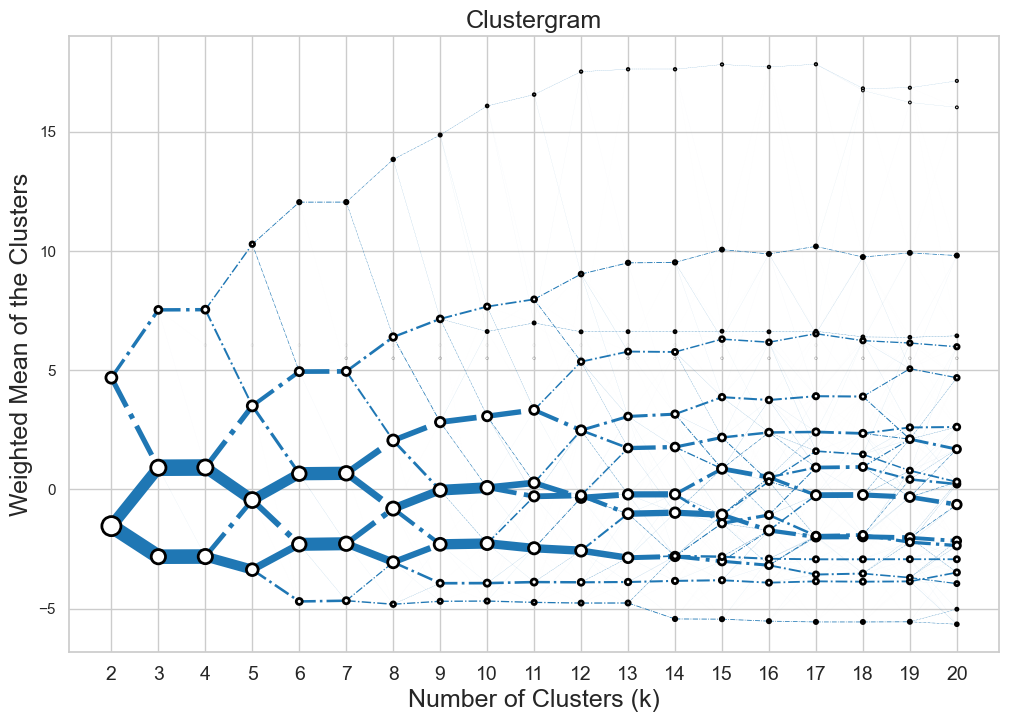

In [32]:
# plot cgram
sb.set(style='whitegrid')

cgram_kmeans_pca.plot(
    size=0.5,
    linewidth=0.5,
    cluster_style={"color": "white", "edgecolor": "black"},
    line_style={"color": "tab:blue", "linestyle": "-."},
    figsize=(12, 8),
)

# Set x-axis to display only integers and adjust fontsize
plt.xticks(range(2,21), fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=18)
plt.ylabel('Weighted Mean of the Clusters', fontsize=18)
plt.title("Clustergram", fontsize=18)

# Save figure
plt.savefig("clustergram_kmeans.png")

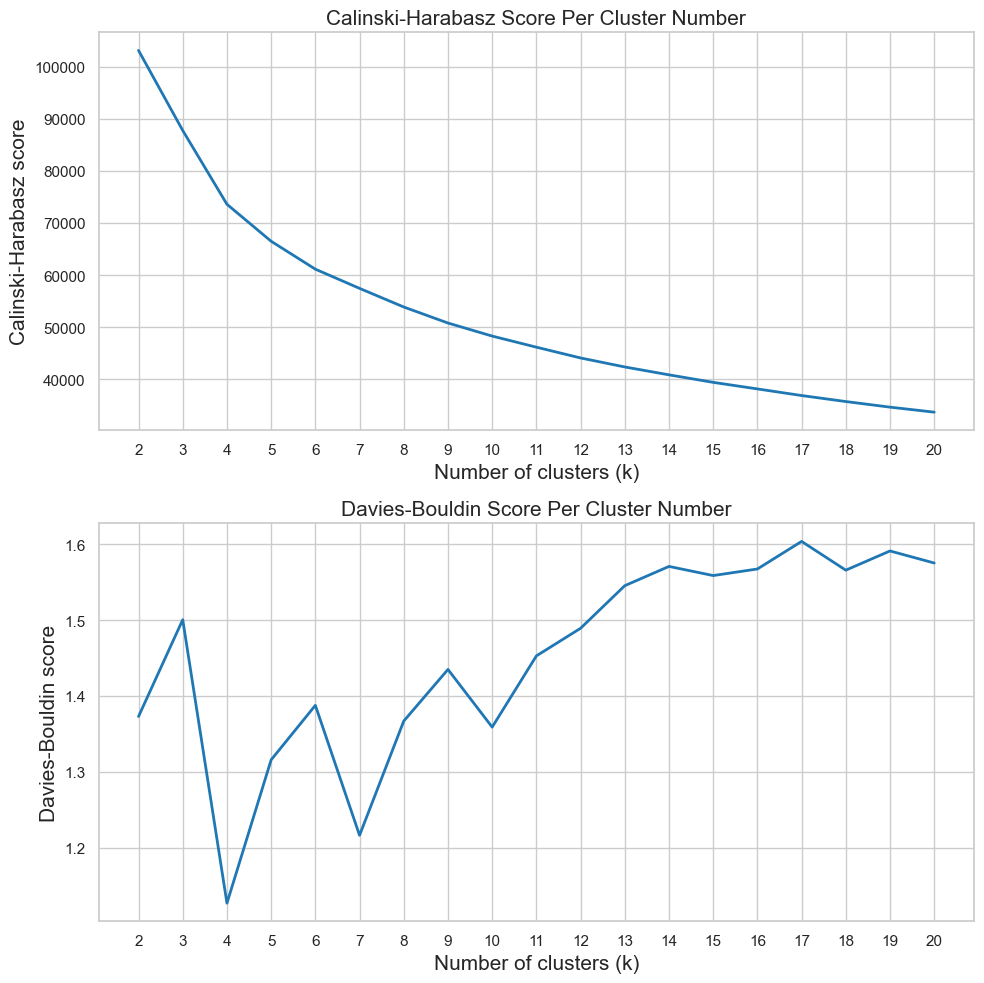

In [33]:
# Goodness of fit tests for the amount of clusters
# We use the Davies-Bouldin and Calinski-Harabasz scores, higher is better for both

# Calinski-Harabasz score: the within-cluster variance divided by the between-cluster variance.
# Davies-Bouldin score: The score is defined as the average similarity measure of each cluster with its most similar cluster, 
#  where similarity is the ratio of within-cluster distances to between-cluster distances. 
#  Thus, clusters which are farther apart and less dispersed will result in a better score.

# Range for cluster number
K = range(2,21)

# getting the scores
kmeansch_pca = cgram_kmeans_pca.calinski_harabasz_score()
kmeansdb_pca = cgram_kmeans_pca.davies_bouldin_score()

# Plotting both the Davies-Bouldin score and the Calinski-Harabasz score per cluster amount
fig, axs = plt.subplots(2, figsize=(10, 10))

# Plot Calinski-Harabasz score
axs[0].plot(K, kmeansch_pca, linewidth=2, color='tab:blue')
axs[0].set_xlabel("Number of clusters (k)", fontsize=15)
axs[0].set_ylabel("Calinski-Harabasz score", fontsize=15)
axs[0].tick_params(axis='y')
axs[0].grid(True)
axs[0].set_xticks(range(2,21))
axs[0].set_title('Calinski-Harabasz Score Per Cluster Number', fontsize=15)

# Plot Davies-Bouldin score
color = 'tab:red'
axs[1].plot(K, kmeansdb_pca, linewidth=2, color='tab:blue')
axs[1].set_xlabel("Number of clusters (k)", fontsize=15)
axs[1].set_ylabel("Davies-Bouldin score", fontsize=15)
axs[1].tick_params(axis='y')
axs[1].grid(True)
axs[1].set_xticks(range(2,21))
axs[1].set_title('Davies-Bouldin Score Per Cluster Number', fontsize=15)
plt.tight_layout()
plt.show()

# Save figure
fig.savefig("kmeans_perf.png")

In [34]:
# saving clustergram
with open('clustergram_kmeans_pca.pickle','wb') as f:
    pickle.dump(cgram_kmeans_pca, f)

### Clustermap with 8 Clusters

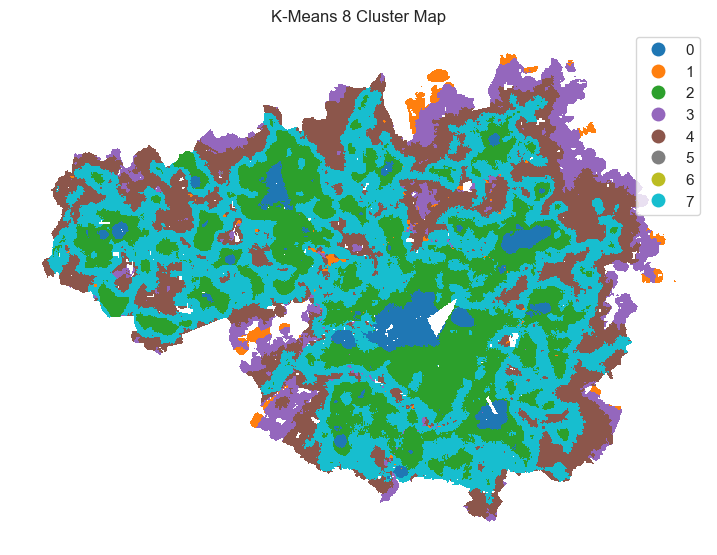

In [35]:
# Plotting results, 8 clusters
popgridsub["Kmeans_cluster_label8"] = cgram_kmeans_pca.labels[8]
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
popgridsub.plot(
    column="Kmeans_cluster_label8",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()

# Display the map
plt.title("K-Means 8 Cluster Map")
plt.show()

In [36]:
# subset of popgridsub to only contain the cluster labels and geometry
popgridsub8 = popgridsub[["Kmeans_cluster_label8", "geometry"]]

In [37]:
# subset of popgridsub to only contain the relevant health variables
mentalhealth8 = healthdata[["ID", "Yrpotlife", "Comilldis", "Obes_Per_Obesprev_y15", "Cancer_Per_cancerPrev_y17", "geometry"]]
mentalhealth8 = mentalhealth8.rename(columns={'Yrpotlife': 'Premature Deaths', 
                                              'Comilldis': 'Comparative Illness and Disability', 
                                              'Obes_Per_Obesprev_y15': 'Obesity Prevalence',
                                              'Cancer_Per_cancerPrev_y17': 'Cancer Prevalence'})

In [38]:
# spatial join
joined_data8 = gpd.sjoin(mentalhealth8, popgridsub8, how='inner', predicate='intersects')

# calculating the most common cluster label for each neighborhood and for both cluster models
majority_cluster_kmeans8 = joined_data8.groupby('ID')['Kmeans_cluster_label8'].apply(lambda x: x.mode())

# calculating the diversity of the labels using Shannon entropy
def calculate_entropy(labels):
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    proportions = label_counts / label_counts.sum()
    entropy = -np.sum(proportions * np.log2(proportions))
    return entropy

# apply function
cluster_diversity_kmeans8 = joined_data8.groupby('ID')['Kmeans_cluster_label8'].apply(calculate_entropy)

# merging the cluster majority and cluster diversity
mentalhealth8 = mentalhealth8.merge(majority_cluster_kmeans8, on='ID')
mentalhealth8 = mentalhealth8.merge(cluster_diversity_kmeans8, on='ID')

# renaming
mentalhealth8 = mentalhealth8.rename(columns={'Kmeans_cluster_label8_x': 'Majority Cluster', 'Kmeans_cluster_label8_y': 'Cluster Diversity'})

In [39]:
# checking data
mentalhealth8.head(5)

,ID,Premature Deaths,Comparative Illness and Disability,Obesity Prevalence,Cancer Prevalence,geometry,Majority Cluster,Cluster Diversity
0,1,73.298,139.960,8.883782,2.308713,"MULTIPOLYGON (((371172.854 411677.763, 371171....",2,0.969456
1,2,70.453,122.767,8.775058,2.324005,"MULTIPOLYGON (((371710.608 411870.891, 371719....",2,0.751808
2,3,60.683,87.251,8.348821,2.521615,"MULTIPOLYGON (((371146.001 413306.000, 371154....",4,1.520471
3,4,66.842,101.857,8.538339,2.487377,"MULTIPOLYGON (((371628.421 413041.967, 371623....",2,-0.000000
4,5,59.963,96.842,8.621558,2.383783,"MULTIPOLYGON (((372209.845 412244.211, 372253....",2,0.766691


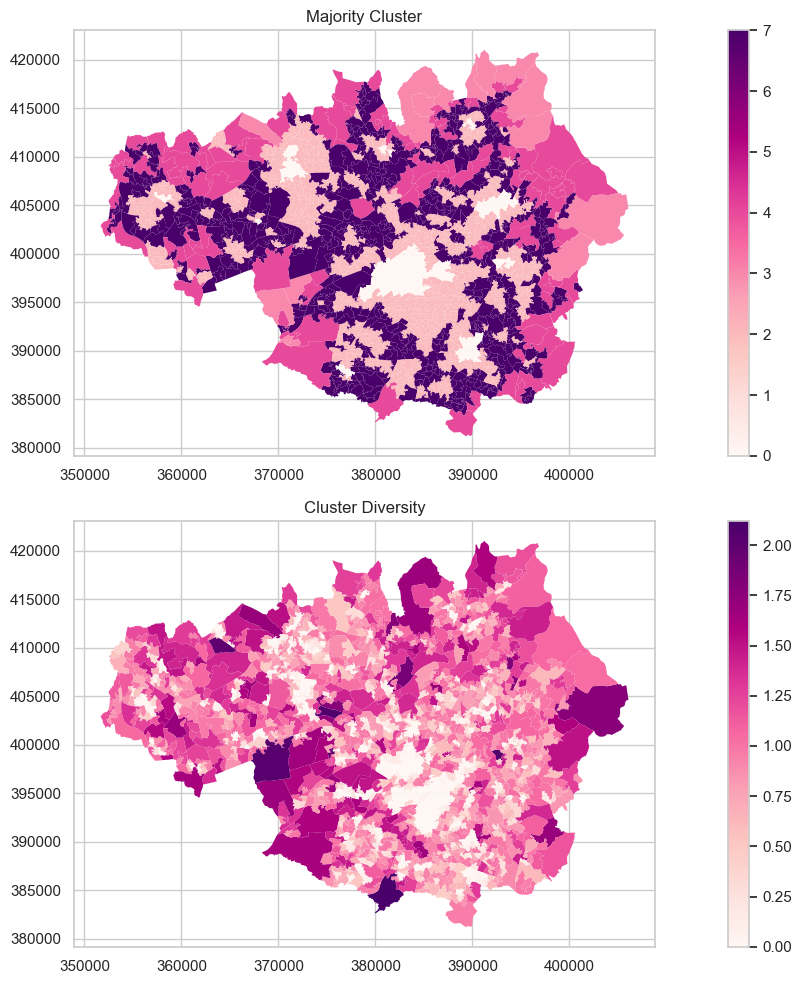

In [40]:
# Plotting the majority and diversity variables
fig, axs = plt.subplots(2, figsize=(15,10))
mentalhealth8.plot(column='Majority Cluster', ax=axs[0],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[0].set_title("Majority Cluster")
mentalhealth8.plot(column='Cluster Diversity', ax=axs[1],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[1].set_title("Cluster Diversity")
plt.tight_layout()

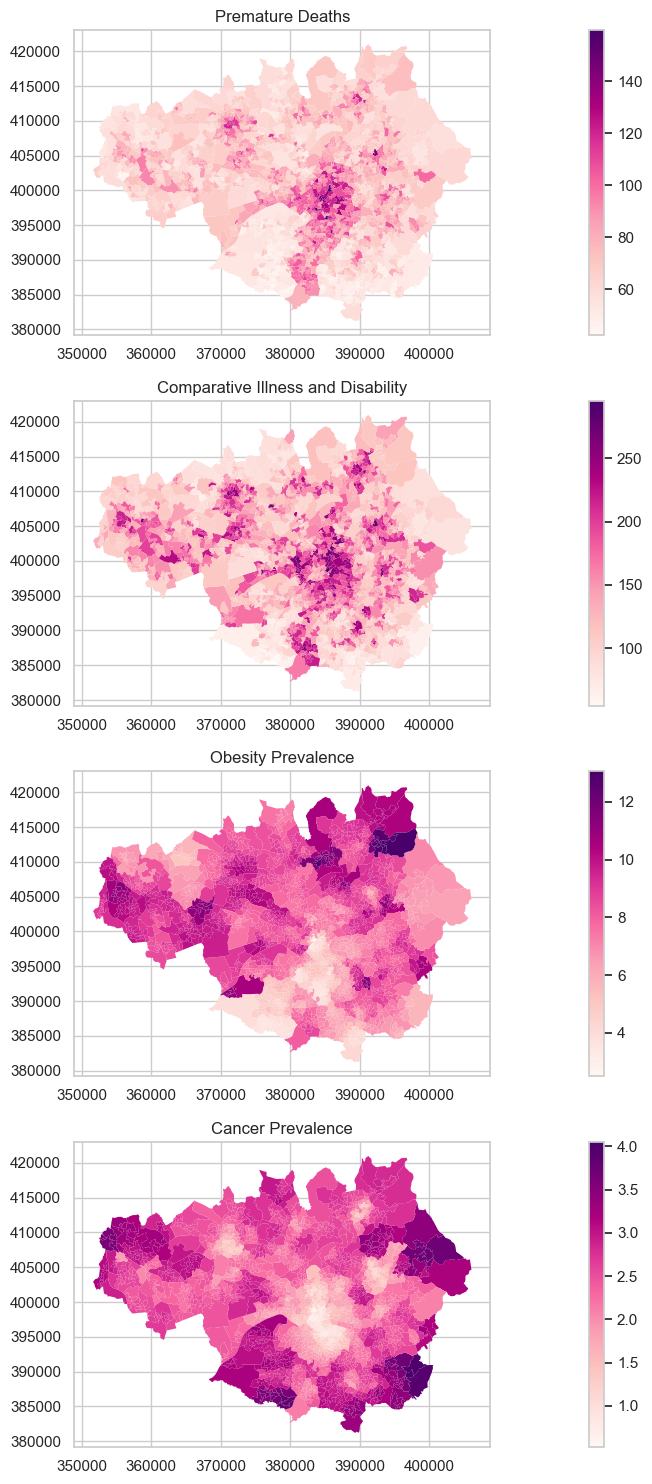

In [41]:
# Plotting health variables
fig, axs = plt.subplots(4, figsize=(20,15))
mentalhealth8.plot(column='Premature Deaths', ax=axs[0],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[0].set_title("Premature Deaths")
mentalhealth8.plot(column='Comparative Illness and Disability', ax=axs[1],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[1].set_title("Comparative Illness and Disability")
mentalhealth8.plot(column='Obesity Prevalence', ax=axs[2],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[2].set_title("Obesity Prevalence")
mentalhealth8.plot(column='Cancer Prevalence', ax=axs[3],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[3].set_title("Cancer Prevalence")

plt.tight_layout()

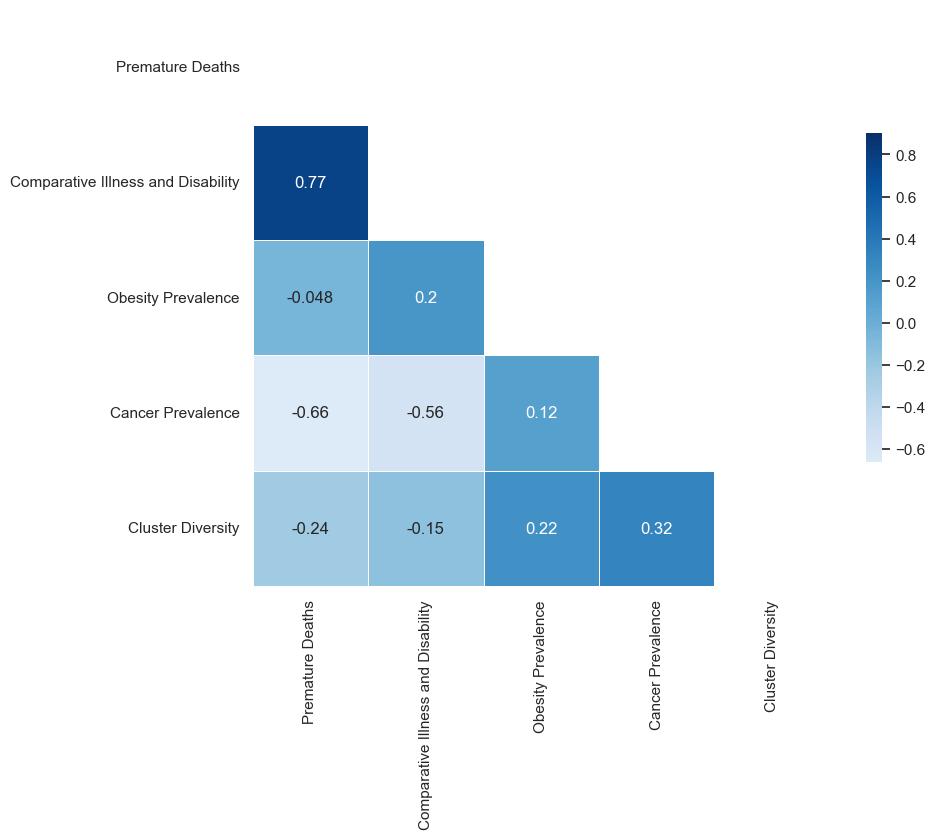

In [42]:
# correlation matrix of the variables but not the majority variable due to it being nominal
sb.set_theme(style="white")

# Compute the correlation matrix
corr = mentalhealth8[["Premature Deaths", 
                      "Comparative Illness and Disability",
                      "Obesity Prevalence",
                      "Cancer Prevalence",
                      "Cluster Diversity"]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 9))

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, cmap='Blues', vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# Save figure
plt.tight_layout()
f.savefig("correlationplot.png")

In [43]:
# kruskal-wallis test for the nominal cluster majority variable to see if the distributions of the health outcomes
# differ for each cluster majority value

# grouped variable
clustermajority_kmeans8 = mentalhealth8.groupby('Majority Cluster')

# health outcomes
health_outcomes = ["Premature Deaths", 
                   "Comparative Illness and Disability",
                   "Obesity Prevalence",
                   "Cancer Prevalence"]

# kruskal-wallis test for each of the health variables with the cluster majority variable
for x in health_outcomes:
    # for each cluster (K-means)
    data = [group[x].values for _, group in clustermajority_kmeans8]
    # kruskal-wallis test
    stat, p = kruskal(*data)
    print('Variable: {0:15s}  Statistics={1:<10.3f}  p={2:<10.3f}'.format(x, stat, p))

Variable: Premature Deaths  Statistics=249.768     p=0.000     
Variable: Comparative Illness and Disability  Statistics=208.330     p=0.000     
Variable: Obesity Prevalence  Statistics=47.665      p=0.000     
Variable: Cancer Prevalence  Statistics=357.352     p=0.000     


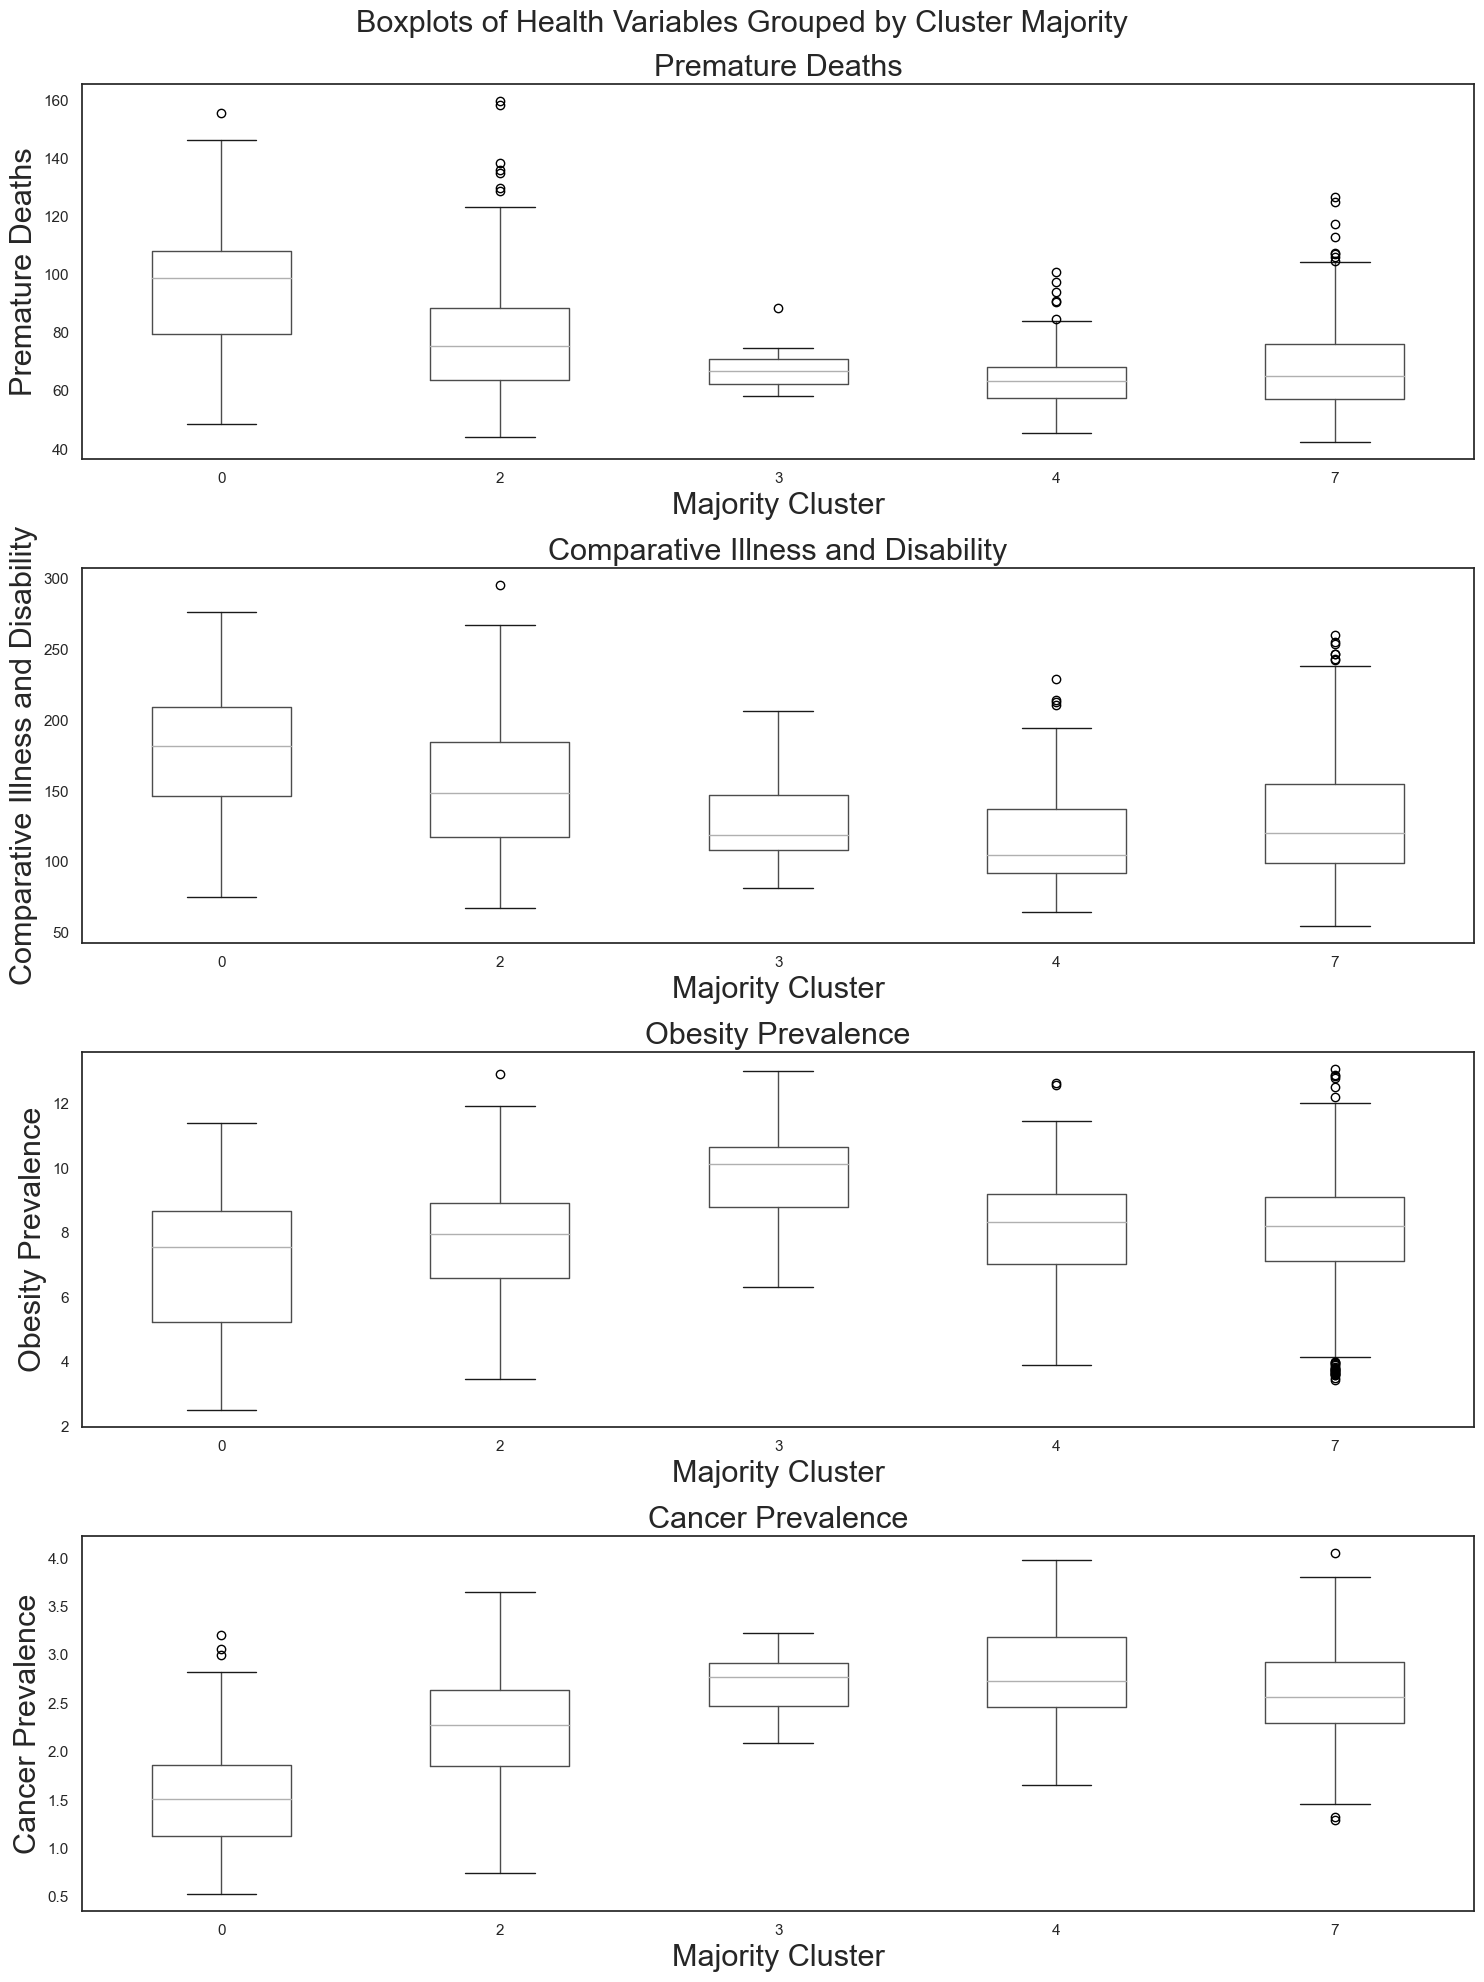

In [44]:
# boxplots to show the distributions of the health variables per cluster majority value

fig, axs = plt.subplots(len(health_outcomes), figsize=(15, 20))
for i, x in enumerate(health_outcomes):
    mentalhealth8.boxplot(column=x, by='Majority Cluster', grid=False, ax=axs[i])
    axs[i].set_title(x, fontsize=22)
    axs[i].set_xlabel('Majority Cluster', fontsize=22)
    axs[i].set_ylabel(x, fontsize=22)

plt.suptitle('Boxplots of Health Variables Grouped by Cluster Majority', y=0.99, fontsize=22)
plt.tight_layout()
plt.show()
fig.savefig("boxplots.png")